# 道具爬虫整理

以撒有道具和饰品都是各种各样的, 此处分别扣取饰品和道具, 一起做识别训练 

## 道具的css 字符串内容

In [1]:
# 这部分手动从网页上下载下啦, 估计是动态加载的, 但是信息密度很高, 直接手动复制一次就完成
with open("./items.css") as file:
    css_content = file.read()
css_content = css_content.replace("<style>", "").replace("</style>", "")

## 饰品的css字符串

In [2]:
# 这部分手动从网页上下载下啦, 估计是动态加载的, 但是信息密度很高, 直接手动复制一次就完成
with open("./trinket.css") as file:
    css_content = file.read()
trinket_css_content = css_content.replace("<style>", "").replace("</style>", "")

In [3]:
# !rm datasets.zip
# !rm -rf datasets/

In [4]:
print(css_content[:100] + " ...")


.mw-collapsible-toggle{float:right;-moz-user-select:none;-webkit-user-select:none;-ms-user-select:n ...


### 用正则表达式得到css  sprite图的id位置映射

In [51]:
import re
import matplotlib.pyplot as plt

def re_match_id_name(text):
    pattern = r'\bcollectibles_\d{3}\b'
    id_name = ""
    match = re.search(pattern, text)

    if match:
        matched_text = match.group(0)
    else:
        print("发现错!")
    return id_name
    
def re_match_values(text, parse_first=False):
    pattern = r'\{(.+?)\}' #r"\{.*?\}"
    match = re.search(pattern, text)
    x, y = 0, 0 # (0,0) 是空白,是有问题的
    if match:
        matched_text = match.group(1)
        key, values = matched_text.split(":")
        x, y = [int(i.replace("px", ""))*-1 for i in values.split(" ")]
        if x == 0 and y == 0 and not parse_first:
            print("出现错误!")
    return x, y


def get_css_mapping_dict(css_content, pattern=r'\bcollectibles_\d{3}\b', parse_first=False):
    id_mapping_dict = {}
    matches = re.findall(pattern, css_content)

    for id_name in matches:    
        match_index = css_content.find(id_name)
        if match_index == -1:
            break
        text = css_content[match_index:-1]
        x, y = re_match_values(text, parse_first=parse_first)
        id_mapping_dict[id_name] = {"x":x, "y":y}
    return id_mapping_dict


# parse_first 是否解析雪碧图的第一个0,0位置
id_mapping_dict = get_css_mapping_dict(css_content, pattern=r'\bcollectibles_\d{3}\b')
trinket_id_mapping_dict = get_css_mapping_dict(trinket_css_content, pattern=r'\btrinket_\d{3}\b', parse_first=True)
print("id_mapping_dict", len(id_mapping_dict))
print("trinket_id_mapping_dict", len(trinket_id_mapping_dict))

id_mapping_dict 721
trinket_id_mapping_dict 189


In [52]:
# id_mapping_dict
# {'collectibles_001': {'x': 32, 'y': 0},
#  'collectibles_002': {'x': 64, 'y': 0},
#  'collectibles_003': {'x': 96, 'y': 0},
#  'collectibles_004': {'x': 128, 'y': 0},
#  'collectibles_005': {'x': 160, 'y': 0},
#  'collectibles_006': {'x': 192, 'y': 0},
#  'collectibles_007': {'x': 224, 'y': 0},

In [53]:
# trinket_id_mapping_dict
# {'trinket_001': {'x': 0, 'y': 0},
#  'trinket_002': {'x': 32, 'y': 0},
#  'trinket_003': {'x': 64, 'y': 0},
#  'trinket_004': {'x': 96, 'y': 0},
#  'trinket_005': {'x': 128, 'y': 0},
#  'trinket_006': {'x': 160, 'y': 0},

## 读取解析物品html 表格

In [54]:
# 其他的元素是静态的数据, 直接读取解析就可以了
from PIL import Image
import requests
from lxml import etree
from urllib.parse import urljoin

def cut_image(x, y, pil_image):
    crop_img = pil_image.crop((x, y, x+32, y+32))
    return crop_img

def plot_images(images:Image, images_per_row = 9, figsize=(5,5)):  # pil 的图片才能plot
    plt.figure(figsize=figsize)

    # 获取第一张图片的尺寸，假设所有图片尺寸都相同
    image_width, image_height = images[0].size

    if len(images) > images_per_row:
        # 计算总的行数
        total_rows = len(images) // images_per_row
        total_rows += 1 if len(images) % images_per_row > 0 else 0 # 有余数就多加一行就可以了
    else:
        images_per_row = len(images)
        total_rows = 1
        
    # 创建一个新的空白图片，尺寸为所有图片拼接后的尺寸
    canvas_width = images_per_row * image_width
    canvas_height = total_rows * image_height
    canvas = Image.new('RGB', (canvas_width, canvas_height))

    # 逐行逐列粘贴图片
    for i, image in enumerate(images):
        row = i // images_per_row
        col = i % images_per_row

        # 计算当前图片在画布上的位置
        left = col * image_width
        top = row * image_height

        # 粘贴图片
        canvas.paste(image, (left, top))
    plt.imshow(canvas)
    plt.show()

In [55]:
base_url = "https://isaac.huijiwiki.com/"


url = "https://isaac.huijiwiki.com/wiki/%E9%81%93%E5%85%B7"

def parse_tr_list(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36',

    }
    response = requests.get(url, headers=headers)
    print(response.status_code)
    html = response.text
    xpath_head = etree.HTML(html)
    tr_list = xpath_head.xpath('//*[@id="mw-content-text"]/div[1]/table/tbody/tr')[1:]
    return tr_list

tr_list = parse_tr_list(url)
print("tr_list", len(tr_list))
import time
time.sleep(10)
trinket_tr_list = parse_tr_list("https://isaac.huijiwiki.com/wiki/%E9%A5%B0%E5%93%81")
print("trinket_tr_list", len(trinket_tr_list))

200
tr_list 719
200
trinket_tr_list 188


In [56]:
# 梯子的问题

### 匹配切好的雪碧图子图和表格列表的数据

In [57]:
pil_image = Image.open("Collectibles_sprite.png")
trinket_pil_image  = Image.open("./Trinket_sprite.png")

(32, 32)


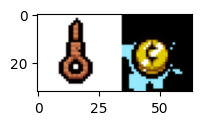

In [58]:
t_image = cut_image(0, 32, pil_image)
tt_image = cut_image(0, 0, trinket_pil_image)
print(t_image.size)

check_images = [t_image, tt_image]
plot_images(check_images, figsize=(2, 2))

In [59]:
import os
os.makedirs("./cus_data", exist_ok=True)

(64, 64)


/var/folders/cy/wqknl_551svg3frfqms_03440000gn/T/ipykernel_98587/683442369.py:5: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  original_image = t_image.resize((64, 64), Image.NONE)


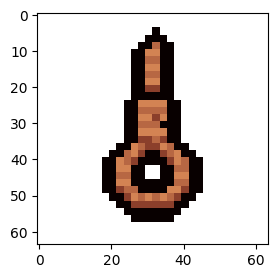

In [60]:
# 像素画的无损放大
from PIL import Image
plt.figure(figsize=(3,3))

original_image = t_image.resize((64, 64), Image.NONE)
print(original_image.size)
plt.imshow(original_image)
plt.show()

In [35]:
# table_texts

In [84]:

def update_data_dict(id_mapping_dict, tr_list, pil_image, index_offset=0):
    for index, i in enumerate(tr_list):
        index += index_offset
        table_texts = i.xpath(".//text()")
        print(table_texts)
        part_url = i.xpath(".//a/@href")[0]
        full_url = urljoin(base_url, part_url)

        id_name = i.xpath(".//a/span/@id")[0]
        print(full_url)
        print(id_name)  # 这个是类别, 按照数字来
        id_value = id_name[-3:]
        print("id_value", id_value, f"new_id: {index}")

        x,y = id_mapping_dict[id_name]['x'], id_mapping_dict[id_name]['y']
        id_mapping_dict[id_name]['en'] = table_texts[0]
        id_mapping_dict[id_name]['zh'] = table_texts[1]
        id_mapping_dict[id_name]['level'] = table_texts[2]
        id_mapping_dict[id_name]['type'] = table_texts[3]
        id_mapping_dict[id_name]['level2'] = table_texts[4]
        id_mapping_dict[id_name]['?'] = table_texts[5]
        id_mapping_dict[id_name]['desc'] = table_texts[6]
        id_mapping_dict[id_name]['new_id'] = index
        crop_img = cut_image(x, y, pil_image)
#         resized_img = crop_img.resize((32*2, 32*2), Image.NONE)  # 放大了这个sprite图  # 此处的缩放, 有影响的
        # 如果要64的话,就是上面那个了, 试试,

        resized_img = crop_img
    
        resized_img.save(f"./cus_data/{index}.png")   # 会互相覆盖的, 那么就需要把他们合并到一块
        id_mapping_dict[id_name]["image"] = f"./cus_data/{index}.png"
    #     plt.figure(figsize=(2, 2))
    #     plt.imshow(crop_img)
    #     plt.show()    
        print()
    return id_mapping_dict


id_mapping_dict = update_data_dict(id_mapping_dict, tr_list, pil_image)

['The Sad Onion', '悲伤洋葱', '1', '道具', '3', '/', '射速上升。']
https://isaac.huijiwiki.com/wiki/C1
collectibles_001
id_value 001 new_id: 0

['The Inner Eye', '内眼', '2', '道具', '2', '/', '角色每次发射3颗泪弹。']
https://isaac.huijiwiki.com/wiki/C2
collectibles_002
id_value 002 new_id: 1

['Spoon Bender', '弯勺魔术', '3', '道具', '3', '/', '角色的泪弹获得追踪效果。']
https://isaac.huijiwiki.com/wiki/C3
collectibles_003
id_value 003 new_id: 2

["Cricket's Head", '柯吉猫的头', '4', '道具', '4', '/', '泪弹变大，击退效果上升，伤害上升。']
https://isaac.huijiwiki.com/wiki/C4
collectibles_004
id_value 004 new_id: 3

['My Reflection', '我的镜像', '5', '道具', '2', '/', '角色的泪弹会飞回角色身边。']
https://isaac.huijiwiki.com/wiki/C5
collectibles_005
id_value 005 new_id: 4

['Number One', '小号', '6', '道具', '2', '/', '射程下降，射速上升。']
https://isaac.huijiwiki.com/wiki/C6
collectibles_006
id_value 006 new_id: 5

['Blood of the Martyr', '殉道者之血', '7', '道具', '3', '/', '伤害上升。']
https://isaac.huijiwiki.com/wiki/C7
collectibles_007
id_value 007 new_id: 6

['Brother Bobby', '波比兄弟', '8',


['Key Piece 1', '钥匙碎片1', '238', '道具', '0', '/', '收集两个钥匙碎片可以挑战超级撒但，天使房转换率上升。']
https://isaac.huijiwiki.com/wiki/C238
collectibles_238
id_value 238 new_id: 233

['Key Piece 2', '钥匙碎片2', '239', '道具', '0', '/', '收集两个钥匙碎片可以挑战超级撒但，天使房转换率上升。']
https://isaac.huijiwiki.com/wiki/C239
collectibles_239
id_value 239 new_id: 234

['Experimental Treatment', '实验性疗法', '240', '道具', '1', '/', '属性随机上升下降。']
https://isaac.huijiwiki.com/wiki/C240
collectibles_240
id_value 240 new_id: 235

['Contract from Below', '地狱契约', '241', '道具', '3', '/', '清理房间会生成双倍的掉落物。']
https://isaac.huijiwiki.com/wiki/C241
collectibles_241
id_value 241 new_id: 236

['Infamy', '耻辱假面', '242', '道具', '2', '/', '角色有概率抵挡敌人的泪弹。']
https://isaac.huijiwiki.com/wiki/C242
collectibles_242
id_value 242 new_id: 237

['Trinity Shield', '三位一体盾', '243', '道具', '2', '/', '抵挡泪弹的盾牌。']
https://isaac.huijiwiki.com/wiki/C243
collectibles_243
id_value 243 new_id: 238

['Tech.5', '科技0.5', '244', '道具', '3', '/', '额外发射随机特效激光。']
https://isaac.huijiwiki.com/wiki


['D infinity', '无限面骰', '489', '道具', '4', '2', '可以作为任意骰子使用。']
https://isaac.huijiwiki.com/wiki/C489
collectibles_489
id_value 489 new_id: 484

["Eden's Soul", '伊甸的灵魂', '490', '道具', '3', '12,一次性使用', '使用后，道具+2。']
https://isaac.huijiwiki.com/wiki/C490
collectibles_490
id_value 490 new_id: 485

['Acid Baby', '毒瘾宝宝', '491', '道具', '2', '/', '生成胶囊的跟班。']
https://isaac.huijiwiki.com/wiki/C491
collectibles_491
id_value 491 new_id: 486

['YO LISTEN!', '嘿，听好！', '492', '道具', '2', '/', '探测隐藏的东西，幸运上升。']
https://isaac.huijiwiki.com/wiki/C492
collectibles_492
id_value 492 new_id: 487

['Adrenaline', '肾上腺素', '493', '道具', '2', '/', '空的心之容器越多，伤害越高。']
https://isaac.huijiwiki.com/wiki/C493
collectibles_493
id_value 493 new_id: 488

["Jacob's Ladder", '雅各布天梯', '494', '道具', '3', '/', '发射会生成电弧的泪弹。']
https://isaac.huijiwiki.com/wiki/C494
collectibles_494
id_value 494 new_id: 489

['Ghost Pepper', '断魂椒', '495', '道具', '3', '/', '概率发射火焰。']
https://isaac.huijiwiki.com/wiki/C495
collectibles_495
id_value 495 new_id:

In [85]:
trinket_index_offset = len(tr_list)# 从道具的最后一个id上接上去就可以了
print(f"从{trinket_index_offset}开始")
trinket_id_mapping_dict = update_data_dict(trinket_id_mapping_dict, 
                                           trinket_tr_list ,
                                           trinket_pil_image, 
                                           index_offset=trinket_index_offset)

从719开始
['Swallowed Penny', '被吞下的硬币', '1', '饰品', '0', '/', '受伤时生成硬币。']
https://isaac.huijiwiki.com/wiki/T1
trinket_001
id_value 001 new_id: 719

['Petrified Poop', '石化大便', '2', '饰品', '0', '/', '摧毁大便生成物品的概率上升。']
https://isaac.huijiwiki.com/wiki/T2
trinket_002
id_value 002 new_id: 720

['AAA Battery', '7号电池', '3', '饰品', '0', '/', '主动道具差1格时自动充满。']
https://isaac.huijiwiki.com/wiki/T3
trinket_003
id_value 003 new_id: 721

['Broken Remote', '损坏的遥控器', '4', '饰品', '0', '/', '使用主动道具会随机传送。']
https://isaac.huijiwiki.com/wiki/T4
trinket_004
id_value 004 new_id: 722

['Purple Heart', '紫心奖章', '5', '饰品', '0', '/', '提升精英敌人的出现概率。']
https://isaac.huijiwiki.com/wiki/T5
trinket_005
id_value 005 new_id: 723

['Broken Magnet', '断掉的磁铁', '6', '饰品', '0', '/', '角色会吸引硬币。']
https://isaac.huijiwiki.com/wiki/T6
trinket_006
id_value 006 new_id: 724

['Rosary Bead', '念珠段', '7', '饰品', '0', '/', '天使房转换率上升。']
https://isaac.huijiwiki.com/wiki/T7
trinket_007
id_value 007 new_id: 725

['Cartridge', '游戏卡带', '8', '饰品', '0', '/

In [64]:
len(id_mapping_dict)

721

# 合并道具和饰品的 映射表 数据

In [65]:
import numpy as np
key_list = list(id_mapping_dict.keys())
key_list.sort()  # 排序完了, 确实没问题
tail_key = key_list[-1]
tail_key = int(tail_key.split("_")[-1])
print(f"最后一个key: {tail_key}")

最后一个key: 732


In [67]:
732 + 189

921

In [40]:
f"collectibles_{921}"

'collectibles_921'

In [69]:
len(trinket_id_mapping_dict)

189

In [70]:
key_offset = tail_key + 1 # 几乎 1000 个 物品
print(f"key_offset: {key_offset}")
new_trinket_id_mapping_dict = {}
for key, value in trinket_id_mapping_dict.items():
    key_name = f"collectibles_{key_offset}"
    key_offset = key_offset + 1 # 此处是字符串,不是index , 所以直接往后+1位开始就可以

    # type 可以区分出是饰品还是道具, 所以不用增加额外识别字段
    new_trinket_id_mapping_dict[key_name] = value
print("end_key_nun:", key_offset)

key_offset: 733
end_key_nun: 922


In [71]:
len(new_trinket_id_mapping_dict)

189

In [72]:
tail_key + len(trinket_id_mapping_dict)

921

In [74]:
new_trinket_id_mapping_dict

{'collectibles_733': {'x': 0,
  'y': 0,
  'en': 'Swallowed Penny',
  'zh': '被吞下的硬币',
  'level': '1',
  'type': '饰品',
  'level2': '0',
  '?': '/',
  'desc': '受伤时生成硬币。',
  'new_id': 719,
  'image': './cus_data/719.png'},
 'collectibles_734': {'x': 32,
  'y': 0,
  'en': 'Petrified Poop',
  'zh': '石化大便',
  'level': '2',
  'type': '饰品',
  'level2': '0',
  '?': '/',
  'desc': '摧毁大便生成物品的概率上升。',
  'new_id': 720,
  'image': './cus_data/720.png'},
 'collectibles_735': {'x': 64,
  'y': 0,
  'en': 'AAA Battery',
  'zh': '7号电池',
  'level': '3',
  'type': '饰品',
  'level2': '0',
  '?': '/',
  'desc': '主动道具差1格时自动充满。',
  'new_id': 721,
  'image': './cus_data/721.png'},
 'collectibles_736': {'x': 96,
  'y': 0,
  'en': 'Broken Remote',
  'zh': '损坏的遥控器',
  'level': '4',
  'type': '饰品',
  'level2': '0',
  '?': '/',
  'desc': '使用主动道具会随机传送。',
  'new_id': 722,
  'image': './cus_data/722.png'},
 'collectibles_737': {'x': 128,
  'y': 0,
  'en': 'Purple Heart',
  'zh': '紫心奖章',
  'level': '5',
  'type': '饰品',
  '

In [76]:
import copy
new_id_mapping_dict = copy.deepcopy(id_mapping_dict)
# id_mapping_dict.

new_id_mapping_dict.update(new_trinket_id_mapping_dict)
len(new_id_mapping_dict)  # 也是没问题的

910

In [79]:
len(new_id_mapping_dict) == len(new_trinket_id_mapping_dict) + len(id_mapping_dict)

True

In [80]:
new_id_mapping_dict

{'collectibles_001': {'x': 32,
  'y': 0,
  'en': 'The Sad Onion',
  'zh': '悲伤洋葱',
  'level': '1',
  'type': '道具',
  'level2': '3',
  '?': '/',
  'desc': '射速上升。',
  'new_id': 0,
  'image': './cus_data/0.png'},
 'collectibles_002': {'x': 64,
  'y': 0,
  'en': 'The Inner Eye',
  'zh': '内眼',
  'level': '2',
  'type': '道具',
  'level2': '2',
  '?': '/',
  'desc': '角色每次发射3颗泪弹。',
  'new_id': 1,
  'image': './cus_data/1.png'},
 'collectibles_003': {'x': 96,
  'y': 0,
  'en': 'Spoon Bender',
  'zh': '弯勺魔术',
  'level': '3',
  'type': '道具',
  'level2': '3',
  '?': '/',
  'desc': '角色的泪弹获得追踪效果。',
  'new_id': 2,
  'image': './cus_data/2.png'},
 'collectibles_004': {'x': 128,
  'y': 0,
  'en': "Cricket's Head",
  'zh': '柯吉猫的头',
  'level': '4',
  'type': '道具',
  'level2': '4',
  '?': '/',
  'desc': '泪弹变大，击退效果上升，伤害上升。',
  'new_id': 3,
  'image': './cus_data/3.png'},
 'collectibles_005': {'x': 160,
  'y': 0,
  'en': 'My Reflection',
  'zh': '我的镜像',
  'level': '5',
  'type': '道具',
  'level2': '2',
  '?': 

In [82]:
## 增加new_label
id_mapping_dict

import json
json_dumped = json.dumps(new_id_mapping_dict)
with open("id_mapping_dict.json", "w") as file:
    file.write(json_dumped)
print(len(new_id_mapping_dict))

910


In [24]:
1/0 # 下面的不用管, yolov8测试的合成数据, 太麻烦,不如pytorch

ZeroDivisionError: division by zero

In [ ]:
total_str = """# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/gen_cus_data  # dataset root dir 配置绝对路径也行
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:\n"""
empty_value_list = []
for i, v in id_mapping_dict.items():  # 生成yaml
    if v.get("new_id") is None:
        empty_value_list.append(i)
    else:
        total_str = total_str + f'  {v.get("new_id")}: {v.get("en").replace(" ", "_")}' + "\n"
total_str

In [ ]:
# clean nouse id
empty_value_list
for i in empty_value_list:
    del id_mapping_dict[i]

In [ ]:
id_mapping_dict

In [ ]:
num = 0
for i, v in id_mapping_dict.items():
    if num != v.get("new_id"):
        print("something err")
        break
    num += 1
    print("i", i)
    print("v", v)

In [ ]:
with open("./gen_cus_data.yaml", "w") as file:
    file.write(total_str)

In [ ]:
id_mapping_dict

In [ ]:
id_value = int(id_name[-3:-1])
print("id_value", id_value)

## 重新做一个映射表, 因为训练模型的输入需要连续的0-n, 而我们自带的标签是1-n并且中间不连续,调整一下

In [ ]:
# 增加一个新的标签叫做new_label 就可以了
import copy
new_id_mapping_dict = {}
num = 0
for i, v in id_mapping_dict.items():
    print("i", i)
    print("v", v)
    copy_v = copy.deepcopy(v)
    copy_v['new_id'] = 0
    new_id_mapping_dict[i] = copy_v
    num += 1
new_id_mapping_dict

In [ ]:
id_mapping_dict

## 合成类别的训练数据, 合成目标检测的训练数据

### 一般照片情况检查

In [ ]:
phone_image = Image.open("/Users/zhengyiming/Downloads/IMG_4027.png")
x, y = phone_image.size  # 这个尺寸很大
print(x, y)

In [ ]:
rate = 10
crop_phone_image = phone_image.resize((int(x/rate), int(y/rate)))
print("crop_phone_image size", crop_phone_image.size)
crop_phone_image

### 这个缩放比还是可以的, 那我的图像增强就暂时不做缩放类的,只要确保输入也是这个比例  
我的轻微旋转还是需要的, 因为拍照不一定很水平

开始合成训练数据,一张图片训练一个对象,这个应该很简单吧,种类多主要是

## 合成训练数据

In [ ]:
import cv2
image = cv2.imread("/Users/zhengyiming/Downloads/coco128_副本/images/train2017/000000000030.jpg")
plt.imshow(image)
# image

In [ ]:
image.shape[:2]

In [ ]:
## 试一下嘛, 不要完美主义,直接作出最简单的,然后再逐个去完善就可以了

In [ ]:
height, width = image.shape[:2]   # 直接给电脑就可以了
print(height, width)


# 解析标签信息
class_id, x_norm, y_norm, w_norm, h_norm = 58, 0.519219, 0.451121, 0.39825, 0.75729

# 将归一化坐标转换为像素坐标
x, y = int(x_norm * width), int(y_norm * height)
w, h = int(w_norm * width), int(h_norm * height)

# 计算左上角和右下角坐标
left = int(x - w/2)
top = int(y - h/2)
right = int(x + w/2)
bottom = int(y + h/2)

# 绘制边界框
cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
plt.imshow(image)

In [ ]:
### 简单的合成一张有一个随机图片的

In [ ]:

# image_height, image_width = image.shape[:2] 
def convert_to_coco128_label_format(class_id, x, y, width, height, image_height, image_width):
    # 计算目标框的中心点坐标
    center_x = x + width / 2
    center_y = y + height / 2

    # 将中心点和尺寸归一化
    norm_center_x = center_x / image_width
    norm_center_y = center_y / image_height
    norm_width = width / image_width
    norm_height = height / image_height

    # 将归一化值转换为COCO128格式
    coco_label = f"{class_id} {norm_center_x} {norm_center_y} {norm_width} {norm_height}"
    
    return coco_label

# 接下来这个是用来把合成的转化过去的

In [ ]:
import cv2
import numpy as np
import random

def generate_training_data(subgraph_list, background_size, num_subgraphs):
    # 创建背景画布
    background = np.zeros((background_size[1], background_size[0], 3), dtype=np.uint8)
    image_height, image_width = background.shape[:2]
    print("height, widht", height, width)

    # 随机选择子图并合成到背景上
    labels = []
    for _ in range(num_subgraphs):
        try:
            # 从子图列表中随机选择一个子图
            print()
            subgraph_path = random.choice(subgraph_list)
            class_id = int(subgraph_path.replace(".png", "").split("/")[-1])
            print(class_id)

            # 加载子图及其透明度通道
            subgraph = cv2.imread(subgraph_path, cv2.IMREAD_UNCHANGED)
            subgraph_alpha = subgraph[:, :, 3] / 255.0

            # 随机生成子图在背景上的位置
            subgraph_pos = (random.randint(0, background_size[0] - subgraph.shape[1]),
                            random.randint(0, background_size[1] - subgraph.shape[0]))
            print(subgraph_pos)
            x, y = subgraph_pos
            label = convert_to_coco128_label_format(class_id, x, y, 64, 64, image_height, image_width)
            print("label: ", label)
            labels.append(label)

            # 检查子图是否与已有子图重叠
            if np.any(background[subgraph_pos[1]:subgraph_pos[1]+subgraph.shape[0],
                                 subgraph_pos[0]:subgraph_pos[0]+subgraph.shape[1]] != 0):
                continue

            # 将子图合成到背景上
            for c in range(3):
                background[subgraph_pos[1]:subgraph_pos[1]+subgraph.shape[0],
                           subgraph_pos[0]:subgraph_pos[0]+subgraph.shape[1], c] = \
                    subgraph[:, :, c] * subgraph_alpha + \
                    background[subgraph_pos[1]:subgraph_pos[1]+subgraph.shape[0],
                               subgraph_pos[0]:subgraph_pos[0]+subgraph.shape[1], c] * (1 - subgraph_alpha)
        except Exception as e:
            print()
    
    # 随机生成背景颜色
    background_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    background[np.where((background == [0, 0, 0]).all(axis=2))] = background_color

    return background, labels


def gen_train_datasets(train_type, range_start, range_end):  # train / val
    images_path = f"./datasets/gen_cus_data/images/{train_type}"
    labels_path = f"./datasets/gen_cus_data/labels/{train_type}"
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)
        
    meta_subpng_path = "./cus_data/"
    file_list = os.listdir(meta_subpng_path)
    file_list.sort()
    file_list
    
    for i in range(range_start, range_end):
#     for i in range(501, 600):
    
        # 子图PNG列表
        
        subgraph_list = [f'./cus_data/{i}' for i in file_list]  # 这儿就不对了

        # 背景尺寸
        background_size = (571, 428)

        # 合成的子图数量
        num_subgraphs = random.randint(10, 20)

        # 生成训练数据
        training_image ,labels = generate_training_data(subgraph_list, background_size, num_subgraphs)

        # 显示合成的训练数据
        cv2.imwrite(os.path.join(images_path, f"{str(i).zfill(5)}.png"), training_image)
        with open(os.path.join(labels_path, f"{str(i).zfill(5)}.txt"), "w") as file:
            for i in labels:
                file.write(i + "\n")
    
        

    plt.imshow(training_image)
    


# 测试代码
if __name__ == '__main__':
    gen_train_datasets("train", 1, 500)  # train / val
    gen_train_datasets("val", 501, 600)  # train / val

In [ ]:
## 检查生成的训练数据
!zip -r datasets.zip datasets

In [ ]:
pwd

In [ ]:
def plot_label(raw_image, labels):
    height, width = raw_image.shape[:2]   # 直接给电脑就可以了
    print(height, width)
    plt_image = raw_image.copy()


    # 解析标签信息
    for i in range(len(labels)):
        # class_id, x_norm, y_norm, w_norm, h_norm = 58, 0.519219, 0.451121, 0.39825, 0.75729
        class_id, x_norm, y_norm, w_norm, h_norm = labels[i].split(" ")
        class_id = int(class_id)
        x_norm = float(x_norm)
        y_norm = float(y_norm)
        w_norm = float(w_norm)
        h_norm = float(h_norm)

        # 将归一化坐标转换为像素坐标
        x, y = int(x_norm * width), int(y_norm * height)
        w, h = int(w_norm * width), int(h_norm * height)

        # 计算左上角和右下角坐标
        left = int(x - w/2)
        top = int(y - h/2)
        right = int(x + w/2)
        bottom = int(y + h/2)

        # 绘制边界框
        cv2.rectangle(plt_image, (left, top), (right, bottom), (0, 255, 0), 2)
    plt.imshow(plt_image)
    
plot_label(training_image, labels)